In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

In [3]:
from helpers import verify_worksheet, replace_nulls, sum_features_per_software, keep_top_software

## Import and clean 

In [34]:
# 1. READ EXCEL FILE
x_file = 'data/SRsoftwareextraction.xlsx'
sheet_name = 'Table3.AdjudicatedValueOnly'
verify_worksheet(x_file, sheet_name)
orig_df = pd.read_excel(x_file, sheet_name, engine='openpyxl')
replace_nulls(orig_df)
orig_df.dropna(axis=0, how= 'all', thresh=None, subset=None, inplace=True) # Drop empty rows
orig_df.tail()

,name,type,field,search,import,expertaddition,fulltextpdf,autofulltext,tiabscreen,distinctscreen,...,protocol,userroles,monitor,comments,training,support,free,living,publicoutputs,multipleusers
19,SRDR,extraction,healthcare,0,1,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
20,SRDR+,full process,healthcare,0,1,1,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
21,SWIFT-Active Screener,screening,multidiscipline,0,1,1,1,0,1,1,...,1,1,1,0,1,1,0,0,0,1
22,SyRF,full process,healthcare,0,1,0,0,0,1,1,...,1,1,0,0,0,0,1,0,0,1
23,SysRev,full process,multidiscipline,1,1,1,1,0,1,0,...,1,1,1,1,0,1,1,1,1,1


In [35]:
orig_df.to_csv('data/orig_df.csv', index=False)

## SUMMARIZE ALL DATA

In [25]:
sum_df = sum_features_per_software(orig_df, 5) # Keep if there are at least 5 non-null features
sum_df.tail()
summary_df = sum_df[['name', 'number_of_features', 'total_features', 'percent_of_features']]
summary_df = summary_df.sort_values(by=['number_of_features'], ascending=False)
summary_df.head()

,name,number_of_features,total_features,percent_of_features
8,Giotto Compliance,27,30,0.90
11,Nested Knowledge,27,30,0.90
6,DistillerSR,26,30,0.87
7,EPPI-Reviewer Web,25,30,0.83
10,LitStream,23,30,0.77


In [26]:
summary_df.to_csv('data/total_features.csv', index=False)

# # Summarize by feature class

In [107]:
classes_dict = {
    'retrieval':['search', 'import', 'expertaddition', 'fulltextpdf', 'autofulltext'],
    'appraisal': ['tiabscreen', 'distinctscreen', 'dualscreen',
                   'wordhighlight', 'screeninautomation', 'deduplication'],
    'extraction': ['tag', 'extract', 'dualextract', 'riskofbias'],
    'output':['flowdiagram', 'writing', 'citationmanager','visualization', 'export'],
    'admin':['protocol', 'userroles', 'monitor', 'comments', 'training','support'],
    'access': ['free', 'living', 'publicoutputs', 'multipleusers']
    }

In [108]:
# Initialize empty datagrame
ftr_sum_df =  pd.DataFrame(orig_df.name)

for k, v in classes_dict.items():  # For each feature class
    feature_key = k
    feature_value = classes_dict[k] # Store the column/variable names in a list
    ftr = orig_df[feature_value]
    sums = ftr.sum(axis=1, skipna=True, numeric_only=True, min_count=1)
    
    # Make a new df with only the Software name
    ftr_sum_df[feature_key] = sums
    # ftr_sum_df[feature_key] = sums # add the feature amounts per each
    
ftr_sum_df.head()

,name,retrieval,appraisal,extraction,output,admin,access
0,Abstrackr,1,5,1,1,5,2
1,Cadima,2,5,3,2,4,3
2,Colandr,4,6,1,2,3,2
3,COVID-NMA,0,0,0,2,1,3
4,Covidence,3,5,4,2,5,1


In [112]:
# Calculate total features and sort
total = ftr_sum_df.sum(axis=1, skipna=True, numeric_only=True)

ftr_sort_df = ftr_sum_df.assign(total_count=total)
ftr_sort_df.sort_values(by=['total_count', 'retrieval'], ascending=False, inplace=True)

ftr_sort_df.to_csv('data/features_classes_sorted.csv', index=False)
ftr_sort_df.head()

,name,retrieval,appraisal,extraction,output,admin,access,total_count
8,Giotto Compliance,5,6,4,3,6,3,27
11,Nested Knowledge,5,5,2,5,6,4,27
6,DistillerSR,5,6,3,4,6,2,26
7,EPPI-Reviewer Web,4,6,4,3,5,3,25
10,LitStream,2,5,3,3,6,4,23


### Limit to top applications

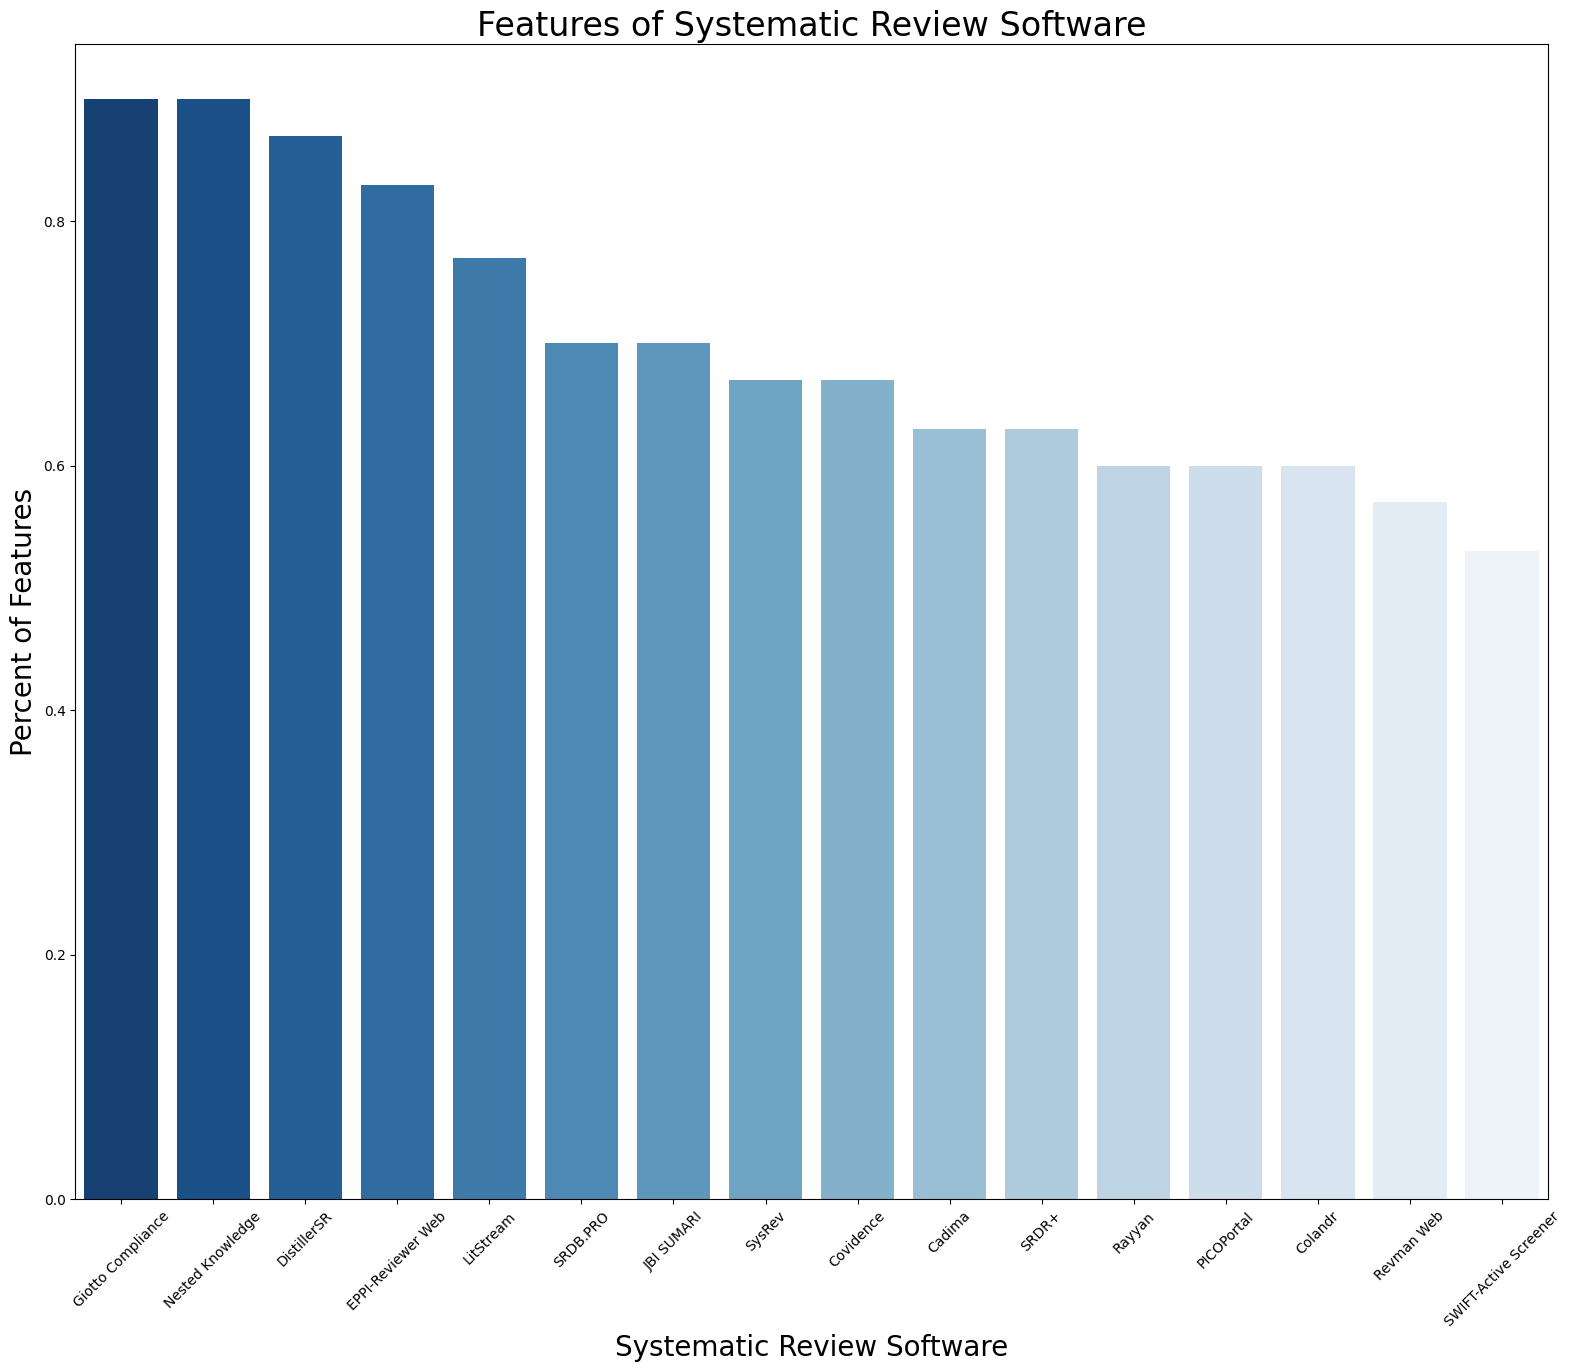

In [28]:
# KEEP THE TOP 16
# Keep only the top 8 softwares
df = keep_top_software(sum_df, "percent_of_features", 16)
df.tail()

name = df['name']
percent = df['percent_of_features']
number = df['number_of_features']

plt.figure(figsize=(19, 15))
ax = sns.barplot(x=name, y=percent, data=sum_df, palette="Blues_r")
ax.set_ylabel('Percent of Features', fontsize=20)
ax.set_xlabel('Systematic Review Software', fontsize=20)
ax.set_title('Features of Systematic Review Software', fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

ax.get_figure().savefig('output/fig1-percent-of-features-top16.png')
